In [3]:
IMG_SIZE=(224, 224)

In [11]:
CLASS_LABEL={
    0: "Anger",
    1: "Contempt",
    2: "Disgust",
    3: "Fear",
    4: "Happy",
    5: "Neutral",
    6: "Sad",
    7: "Surprised"
}

In [4]:
import zipfile
import pathlib
import os
from PIL import Image
import random
import torch
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset

In [34]:
data_path=pathlib.Path("data/")
image_path=data_path/"testing_ds1/images/"

In [ ]:
if pathlib.Path(image_path).is_dir():
    print(f"{data_path/"ProcessedEmotionDataset"} exists... skipping creation")
else: 
    print(f"{image_path} doesn't exits.. creating one. Please etract the zip file first")

data\ProcessedEmotionDataset exists... skipping creation


In [35]:
def data_folder_info(dir_path):
    for dirpath, dirname, filename in os.walk(dir_path):
        print(f"{dirpath} has {len(dirname)} directory and {len(filename)} files")
data_folder_info(image_path)

data\testing_ds1\images has 19 directory and 0 files
data\testing_ds1\images\0 has 0 directory and 8 files
data\testing_ds1\images\1 has 0 directory and 8 files
data\testing_ds1\images\10 has 0 directory and 8 files
data\testing_ds1\images\11 has 0 directory and 8 files
data\testing_ds1\images\12 has 0 directory and 8 files
data\testing_ds1\images\13 has 0 directory and 8 files
data\testing_ds1\images\14 has 0 directory and 8 files
data\testing_ds1\images\15 has 0 directory and 8 files
data\testing_ds1\images\16 has 0 directory and 8 files
data\testing_ds1\images\17 has 0 directory and 8 files
data\testing_ds1\images\18 has 0 directory and 8 files
data\testing_ds1\images\2 has 0 directory and 8 files
data\testing_ds1\images\3 has 0 directory and 8 files
data\testing_ds1\images\4 has 0 directory and 8 files
data\testing_ds1\images\5 has 0 directory and 8 files
data\testing_ds1\images\6 has 0 directory and 8 files
data\testing_ds1\images\7 has 0 directory and 8 files
data\testing_ds1\ima

In [36]:
image_list=list(image_path.glob("**/*.[pj]*g"))
print(f"Total {len(image_list)} images found in {image_path}")

Total 152 images found in data\testing_ds1\images


In [37]:
img_random=image_list[random.choice(range(len(image_list)))]
img=Image.open(img_random)
img_class=img_random.parent.stem
print(f"Image class: {img_class}")
print(f"Image width: {img.width}, height: {img.height}, format: {img.format}")
print(f"Image size: {img.size}, mode: {img.mode}")

Image class: 1
Image width: 2448, height: 3264, format: JPEG
Image size: (2448, 3264), mode: RGB


In [26]:
class EmotionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        self.label2idx = {}

        for subdir in sorted(os.listdir(root_dir)):
            subpath = os.path.join(root_dir, subdir)
            if os.path.isdir(subpath):
                for fname in os.listdir(subpath):
                    if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                        label_name = os.path.splitext(fname)[0].strip()
                        if label_name not in self.label2idx:
                            self.label2idx[label_name] = len(self.label2idx)
                        label = self.label2idx[label_name]
                        self.samples.append((os.path.join(subpath, fname), label))

        print("Labels found:", self.label2idx)
        print("Total samples:", len(self.samples))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


# Example usage
data_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
 ])

dataset = EmotionDataset(image_path, transform=data_transforms)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

print("Dataset size:", len(dataset))
for images, labels in dataloader:
    print(images.size(), labels)
    break

Labels found: {'Anger': 0, 'Contempt': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Sad': 6, 'Surprised': 7}
Total samples: 152
Dataset size: 152
torch.Size([32, 3, 224, 224]) tensor([0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7,
        0, 1, 2, 3, 4, 5, 6, 7])


In [21]:
import torchvision.models as models

def get_resnet34(num_classes=len(CLASS_LABEL), in_channels=3, pretrained=True):
    # Load pretrained ResNet34
    model = models.resnet34(pretrained=pretrained)

    # Modify the first conv layer to accept 1 channel instead of 3
    if in_channels == 1:
        # Old conv1 expects 3 channels: [64, 3, 7, 7]
        weight = model.conv1.weight.data
        model.conv1 = nn.Conv2d(
            in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        # Initialize with mean of pretrained weights
        model.conv1.weight.data = weight.mean(dim=1, keepdim=True)

    # Modify the fully connected layer for your number of classes
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model

model = get_resnet34(num_classes=len(CLASS_LABEL), in_channels=3, pretrained=False)


c:\Users\admin\.conda\envs\env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\admin\.conda\envs\env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [22]:
checkpoint = torch.load('./res224colored_transfer_b2_best_20250903_092840.pth', weights_only=False)
model.load_state_dict(checkpoint['model_state'])

<All keys matched successfully>

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def evaluate_model(model: torch.nn.Module,
                   dataloader: torch.utils.data.DataLoader,
                   class_names: list,
                   device: str = "cuda" if torch.cuda.is_available() else "cpu"):
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            outputs = model(X)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Classification report (precision, recall, f1 for each class)
    report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    return report, cm

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns  # makes heatmap nicer

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


Classification Report:
               precision    recall  f1-score   support

       Anger     0.4444    0.4211    0.4324        19
    Contempt     0.3750    0.1579    0.2222        19
     Disgust     0.3600    0.4737    0.4091        19
        Fear     0.5455    0.3158    0.4000        19
       Happy     0.6190    0.6842    0.6500        19
     Neutral     0.3529    0.6316    0.4528        19
         Sad     0.3571    0.2632    0.3030        19
   Surprised     0.4762    0.5263    0.5000        19

    accuracy                         0.4342       152
   macro avg     0.4413    0.4342    0.4212       152
weighted avg     0.4413    0.4342    0.4212       152



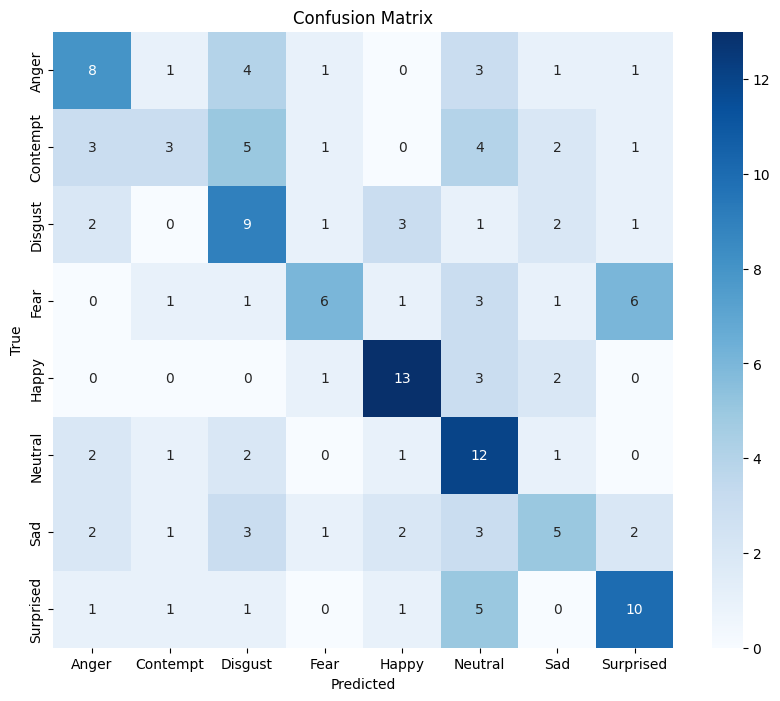

In [27]:
report, cm = evaluate_model(model, dataloader, class_names=list(CLASS_LABEL.values()))

print("Classification Report:\n", report)
plot_confusion_matrix(cm, list(CLASS_LABEL.values()))


In [6]:
data_path=pathlib.Path("data/")
image_path=data_path/"testing_ds2"

In [29]:
if pathlib.Path(image_path).is_dir():
    print(f"{image_path} exists... skipping creation")
else: 
    print(f"{image_path} doesn't exits.. creating one")
    pathlib.Path(image_path).mkdir(parents=True, exist_ok=True)

if len(os.listdir(image_path)) == 0:
    if data_path.exists():
        with zipfile.ZipFile(data_path / "testing_ds2.zip", "r") as zip_asset:
            print("Unzipping data...")
            zip_asset.extractall(data_path)
            print("Done!")
    else:
        print(f"""{data_path / 'testing_ds2.zip'} does not exist, please check the path or download it""")
else:
    print(f"{str(image_path)} is not empty, skipping unzipping")

data\testing_ds2 exists... skipping creation
data\testing_ds2 is not empty, skipping unzipping


In [ ]:
data_folder_info(image_path)

data\testing_ds2 has 2 directory and 1 files
data\testing_ds2\test has 8 directory and 0 files
data\testing_ds2\test\angry has 0 directory and 5 files
data\testing_ds2\test\Contempt has 0 directory and 5 files
data\testing_ds2\test\disgust has 0 directory and 5 files
data\testing_ds2\test\fear has 0 directory and 5 files
data\testing_ds2\test\happy has 0 directory and 5 files
data\testing_ds2\test\neutral has 0 directory and 5 files
data\testing_ds2\test\sad has 0 directory and 5 files
data\testing_ds2\test\surprised has 0 directory and 5 files
data\testing_ds2\train has 8 directory and 0 files
data\testing_ds2\train\angry has 0 directory and 14 files
data\testing_ds2\train\Contempt has 0 directory and 14 files
data\testing_ds2\train\disgust has 0 directory and 14 files
data\testing_ds2\train\fear has 0 directory and 14 files
data\testing_ds2\train\happy has 0 directory and 14 files
data\testing_ds2\train\neutral has 0 directory and 14 files
data\testing_ds2\train\sad has 0 directory a

In [31]:
image_list=list(image_path.glob("**/*.[pj]*g"))
print(f"Total {len(image_list)} images found in {image_path}")

Total 152 images found in data\testing_ds2


In [8]:
if data_path.is_dir():
    data_path.mkdir(parents=True, exist_ok=True)
if image_path.is_dir():
    print(f"{image_path} exists... skipping creation")
else: 
    print(f"{image_path} doesn't exits.. creating one")
    image_path.mkdir(parents=True, exist_ok=True)

def class_info(dir_path):
    class_dirs = [d for d in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, d))]
    for idx, class_name in enumerate(class_dirs):
        print(f'{idx}: "{class_name}",')

class_info(image_path/"train")

data\testing_ds2 exists... skipping creation
0: "angry",
1: "Contempt",
2: "disgust",
3: "fear",
4: "happy",
5: "neutral",
6: "sad",
7: "surprised",


In [20]:
CLASS_LABEL={
    0: "angry",
    1: "Contempt",
    2: "disgust",
    3: "fear",
    4: "happy",
    5: "neutral",
    6: "sad",
    7: "surprised"
}

In [11]:
TEST_BATCH_SIZE=32
IMG_SIZE=(224, 224)

In [12]:
data_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    ])

In [16]:
dataset2= datasets.ImageFolder(
    root=image_path/"train",
    transform=data_transforms,
    target_transform=None
)   

In [26]:
test_loader2 = DataLoader(dataset2, batch_size=TEST_BATCH_SIZE, shuffle=False)

Classification Report:
               precision    recall  f1-score   support

       angry     0.0909    0.0714    0.0800        14
    Contempt     0.0000    0.0000    0.0000        14
     disgust     0.3158    0.4286    0.3636        14
        fear     0.4444    0.2857    0.3478        14
       happy     0.5556    0.7143    0.6250        14
     neutral     0.3462    0.6429    0.4500        14
         sad     0.4000    0.2857    0.3333        14
   surprised     0.4615    0.4286    0.4444        14

    accuracy                         0.3571       112
   macro avg     0.3268    0.3571    0.3305       112
weighted avg     0.3268    0.3571    0.3305       112



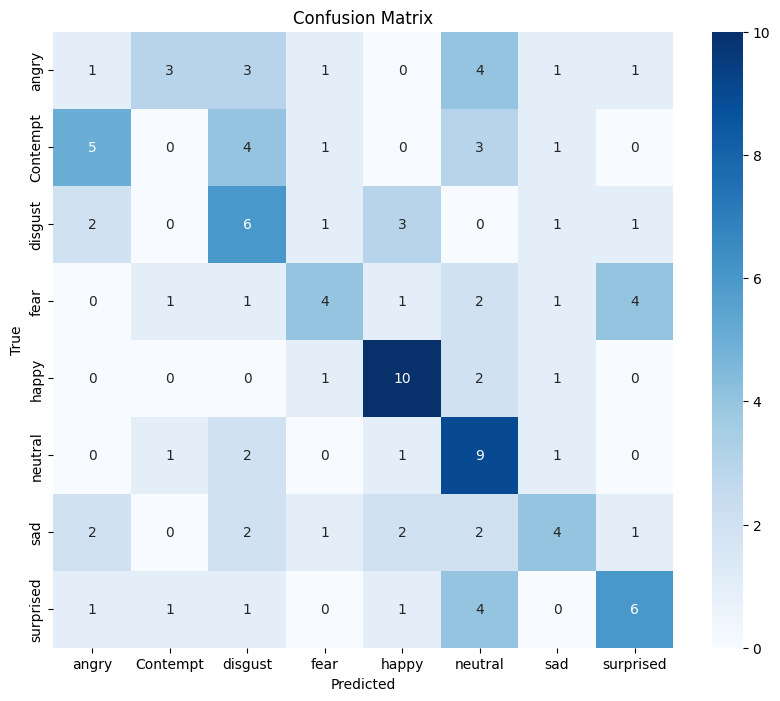

In [27]:
report, cm = evaluate_model(model, test_loader2, class_names=list(CLASS_LABEL.values()))

print("Classification Report:\n", report)
plot_confusion_matrix(cm, list(CLASS_LABEL.values()))